# ECON 490: Good Regression Practice (14)


## Prerequisites: 
--- 
1. Importing data into R.
2. Creating new varables in R.
3. Running OLS regressions.


## Learning Outcomes:  
---
1. Identify and correct for outliers by trimming or winsorizing the dependent variable. 
2. Identify and correct for the problem of multicollinearity.
3. Identify and correct for the problem of heteroskedasticity. 
4. Identify and correct for the problem of non-linearity. 


## 14.1 Dealing with Outliers 

Imagine that we have constructed a dependent variable which contains the earnings growth of individual workers and we see that some worker's earnings increased by more than 400%. We might wonder if this massive change is just a coding error made by the statisticians that produced the data set. Even without that type of error, though, we might worry that the earnings growth of small number of observations are a driving the results of our analysis. If this is the case, we would be producing an inaccurate analysis based on results that are not associated with the majority of our observations. 

The standard practice in these cases is to either winsorize or trim the subset of observations that are used in that regression. Both practices remove the outlier values in the dependent variable to allow us to produce a more accurate empirical analysis. 

<div class="alert alert-block alert-warning">
    
<b>Warning:</b> You should only consider fixing outliers when there is a clear reason to address this issue. Do not apply the tools below if the summary statistics in your data make sense to you in terms of abnormal values. For example, outliers might be a sign that your dependent and explanatory variables have a non-linear relationship. If that is the case you will want to consider including an interaction term that addresses that non-linearity. 
    
</div>

### 14.1.1 Winsorizing your Dependent Variable

Winsorizing is the process of limiting extreme values in the dependent variable. to reduce the effect of (possibly erroneous) outliers. It consists on replacing values below the $a$ percentile by that percentile value, and values above the $b$ percentile by that percentile. Consider the following example using our fake data set:


In [2]:
#Clear the memory from any pre-existing objects
rm(list=ls())

# loading in our packages
library(tidyverse) #This includes ggplot2! 
library(haven)
library(IRdisplay)

#Open the dataset 
fake_data <- read_csv("../econ490-stata/fake_data.csv")  #change me!


-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.5     v dplyr   1.0.7
v tidyr   1.1.4     v stringr 1.4.0
v readr   2.0.2     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Rows: 2861772 Columns: 9

-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
chr (1): sex
dbl (8): workerid, year, birth_year, age, start_year, region, treated, earnings


i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [3]:
quantile(fake_data$earnings, probs = c(0.01,0.99))

1%        99% 
  2037.389 540520.427

In [4]:
min(fake_data$earnings)

[1] 8.881357

In [5]:
max(fake_data$earnings)

[1] 1.9e+08

From the summary statistics above you can see that that the income earned by the individual at the 1st percentile is 2,037.23 and that the lowest earner in the data set earned is 8.88.  

We can also see that income earned by the individual at the 99th percentile is only of 540,525.90 and that the highest earner in the data earned over 190,000,000!

This table suggests to us that there are large outliers in our dependent variable.

We want to get rid of these outliers by winsorizing our data set. What that will mean is replacing the earnings of all observations below the 1st percentile by exactly the earnings of the individual at the 1st percentile. And replacing the earnings of all observations above the 99th percentile by exactly the earnings of the individual at the 99th percentile. 


To winsorize this data, we do the following:

1. Create a new variable with the same values as earnings that we will call it earnings_winsor (`gen earnings_winsor = earnings`). The reason why we can decide to store the winsorized version of the dependent variable as a different variable is just for organizational purposes - we don't want to overwrite the original data set. 
2. If earnings are smaller than 1st percentile, we will replace the values of earnings_winsor with the earnings of the individual at the 1st percentile (stored in Stata in r(p1)).
3. If earnings are larger than 1st percentile, we will replace the values of earnings_winsor with the earnings of the individual at the 99th percentile (stored in Stata in r(p99).


You can run these commands yourself below:

In [15]:
fake_data <- fake_data %>%
        mutate(log_earnings_winsor = ifelse(earnings<2037 ,  log(2037),  ifelse( earnings  > 540520 , log(540520), log(earnings))  )  ) 


Now you will use this new dependent variable in your regression analysis. If the outliers were not creating problems, there will be no change in the results. If they were creating problems, those problems will now be fixed. 

Let's take a look at this by first running the regression from [Module 12]() with the original earning variable. 


In [13]:
lm(data=fake_data, log(earnings) ~ as.factor(sex))



Call:
lm(formula = log(earnings) ~ as.factor(sex), data = fake_data)

Coefficients:
    (Intercept)  as.factor(sex)M  
        10.1384           0.5467  


In [16]:
lm(data=fake_data, log_earnings_winsor ~ as.factor(sex))



Call:
lm(formula = log_earnings_winsor ~ as.factor(sex), data = fake_data)

Coefficients:
    (Intercept)  as.factor(sex)M  
        10.1466           0.5356  


Do you think that in this case the outliers were having a significant impact?

### 14.1.2 Trimming your Dependent Variable 

Trimming consists of replacing both values below the $a$ percentile and values above the $b$ percentile by a missing value. The idea is that when that variable equals a missing value it won't be used in the regression. R by design does not include observations where there are missing variables `NA` in the command `lm()`.

Here are the commands for trimming your variable. 

In [18]:
fake_data <- fake_data %>%
        mutate(log_earnings_trimmed = ifelse(earnings<2037 ,  NA,  ifelse( earnings  > 540520 , NA, log(earnings))  )  ) 


And here is the result of the regression with the new dependent variable. 

In [21]:
lm(data=fake_data, log_earnings_trimmed ~ as.factor(sex))

## 14.2 Multicollinearity 

If two variables are linear combinations of one another they are multicollinear. Ultimately, R will not allow you to include two variables in a regression that are perfect linear combinations of one another, such as a constant, a dummy variable for male and a dummy for female (since female = 1 - male). In all of the regressions above you will see that one of those variables will be dropped from the regression "because of collinearity".


Is this a problem? Not really. Multicollinearity is a sign that a variable is not adding any new information. Notice that with the constant term and a male dummy we can know the mean earnings of the females. In this case, the constant term is by construction the mean earnings of females, and the male dummy gives the earning premium is paid to male workers.

While there are some statistical tests for multicollinearity, nothing beats having the right intuition when running regression. If there is an obvious case where two variables contain basically the same information, you should avoid including both in the analysis. 

For instance, we might have an age variable that includes both years and months (e.g. if a baby is 1 year and 1 month old, then this age variable would be coded as 1 + 1/12 = 1.083). If we included this variable in a regression that also include an age variable that includes only years (e.g the baby's age would be coded as 1) then we would have the problem of multicollinearity. Because they are not perfectly collinear, R might still produce some results but the coefficients on these two variables would be biased. 

## 14.3 Heteroskedasticity 

When we run a linear regression we essentially split the outcome into a (linear) part explained by observables and an error term:
$$ y_i = a + b x_i + e_i$$ 

The standard errors in our coefficients depend on $e_i^2$ (as you might remember from ECON 326). Heteroskedasticity refers to the case where the variance of this projection error depends on the observables $x_i$. For instance, the variance of wages tends to be higher for people who are university educated (there is some people with very high wages) whereas it is small for people who are non-university educated (they tend to be concentrated in smaller paying jobs).  R by defaults assumes that the variance does not depend on the observables, also known as homoskedasticity. It is safe to say that this is an incredibly restrictive assumption.

While there are tests for heteroskedasticity, the more empirical economists rely on including the heteroskedastic consistent standard errors as a default in their regressions. The most standard way to do this is to use another command similar to `lm()` that comes from the `fixest` package. 

In [20]:
library(fixest)

Warning message:
"package 'fixest' was built under R version 4.1.3"


In [23]:
model = feols(log_earnings_trimmed ~ as.factor(sex) , fake_data)


NOTE: 57,232 observations removed because of NA values (LHS: 57,232).



In [24]:
summary(model, vcov="HC1")

OLS estimation, Dep. Var.: log_earnings_trimmed
Observations: 2,804,540 
Standard-errors: Heteroskedasticity-robust 
                 Estimate Std. Error  t value  Pr(>|t|)    
(Intercept)     10.180511   0.001074 9475.687 < 2.2e-16 ***
as.factor(sex)M  0.484686   0.001332  363.857 < 2.2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 1.06373   Adj. R2: 0.045382

Best practices are simply to always use robust standard errors in your ECON 490 project.

## 14.4 Non-linearity

Our regression analysis so far assumes that the relationship between our independent and explanatory variables is linear. If this is not the case, and the relationship is non-linear, then we are getting inaccurate results with our analysis. 

Let's consider an example. We know that earnings increases with age, but what if economic theory predicts that the amount that earnings increases for each year of age when workers are younger is larger than the amount that earnings increases for each year of age when workers are older? Another way to say this is, what if we predict that earnings is increasing with age at a decreasing rate?

We could correct for this in our model by including a new interaction term that is simply age interacted with itself. You learned how to do this in [Module 13](). Let's include this in regression above remembering the age is a continuous variable 

In [27]:
fake_data <- fake_data %>%
        mutate(age2 = age^2 ) 


In [30]:
model = lm(log_earnings_trimmed ~ as.factor(sex) + age + age2, fake_data)

summary(model, vcov="HC1")

There does seem to be some evidence in our regression results that this economic theory is correct since the coefficent on the interaction term is both negative and statistically significant.

<div class="alert alert-info">


**Note:** If there is a theoretical reason for believing that non-linearity exists R provides some tests for non-lineary. You can also created a scatterplot to see if you can observe a non-linear relationship in the data. We covered that approach in [Module 9]().
    
</div>




## 14.4 exercises 
1. Run a regression checking how age, sex and the treatment affect log_earnings. Should we include an interaction $age^2$ interaction term in this particular case? 

In [ ]:
model <- lm()
summary(model, vcov="HC1")

In [ ]:
display_html('<iframe src="https://h5p.open.ubc.ca/wp-admin/admin-ajax.php?action=h5p_embed&id=1211" width="841" height="310" frameborder="0" allowfullscreen="allowfullscreen" title="module 12 q2"></iframe><script src="https://h5p.open.ubc.ca/wp-content/plugins/h5p/h5p-php-library/js/h5p-resizer.js" charset="UTF-8"></script>')

3. For this question we will use a different dataset. We will be using the 2016 census data. First windorize the variable wages. Also make the new winsorized variable logarithmic. Then run a regression with log_winsor_wages as the dependent variable and hdgree (level of education) and immstat (immigration status) as independent variables. Hint (check immstat, it should be a dummy variable!). The correct answer is shown below.
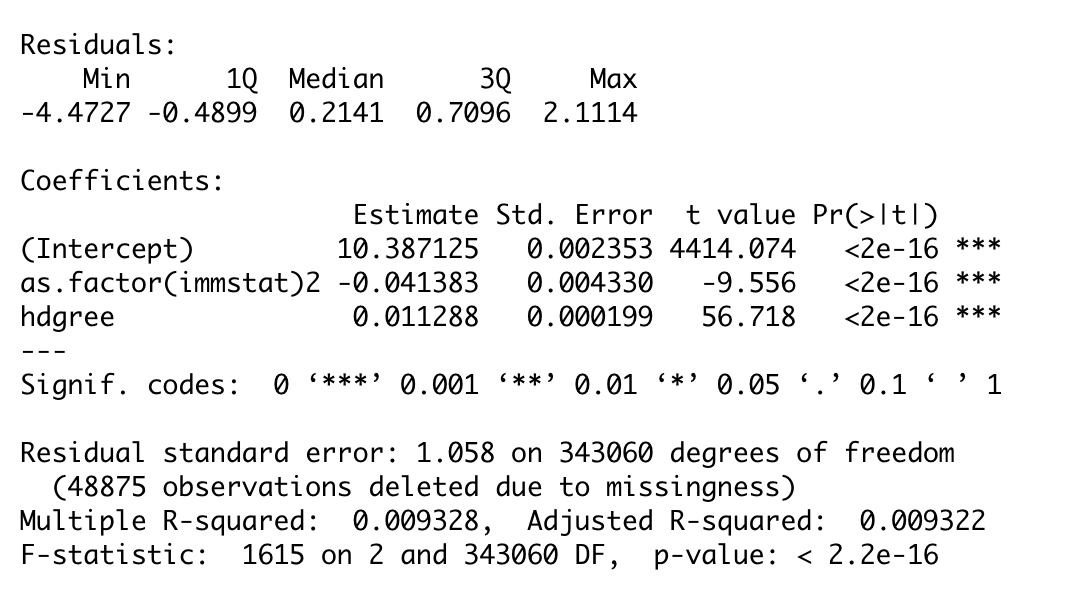

## 14.4 Wrap up 

While it is important to always follow best practices for regression analysis, checking and correcting for outliers, heteroskedaticy, multicollinearity and non-linearity can be more of an art than a science. If you need any guidance on whether or not you need to address these issues please be certain to speak with your instructor or your TA.